In [1]:
import os
import sys

import numpy as np
from astropy import units as u

import sbfit
import sbfit.model


Bad key "text.kerning_factor" on line 4 in
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Load data

Initialize an `ObservationList` object.

In [2]:
observations = sbfit.ObservationList()

Load images into the `ObservationList` object.

In [3]:
image_dir = "a3667/chandra"

obsids = [513, 889, 5751, 5752, 5753, 6292, 6295, 6296]

for obsid in obsids:
    observations.add_observation_from_file(f"a3667/chandra/{obsid}_band1_thresh.img", 
                                           f"a3667/chandra/{obsid}_band1_thresh.expmap", 
                                           f"a3667/chandra/{obsid}_band1_nxb_full.img", 
                                           bkg_norm_type="count",
                                           bkg_norm_keyword="bkgnorm", )

# Read region file

In [4]:
epanda = sbfit.read_region("a3667.reg")

# Extract a profile
The region set loaded in the previous step is used.

The `channel_width` is the size of the radius grid for a profile. The value should be less than the psf width.

In [5]:
a3667_chandra_profile = observations.get_profile(epanda, channel_width=0.5)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 51444.513808 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 51797.187928 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53529.557755 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53534.009225 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53539.451968 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53532.193692 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53536.858264 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53541.426528 from DATE-END'. [astropy.wcs.wcs]


First, let's bin the profile.

/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:265: RuntimeWarning: invalid value encountered in true_divide
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:269: RuntimeWarning: invalid value encountered in true_divide
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:271: RuntimeWarning: invalid value encountered in true_divide
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:273: RuntimeWarning: invalid value encountered in true_divide
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:276: RuntimeWarning: invalid value encountered in true_divide
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:279: RuntimeWarning: invalid value encountered in true_divide
/Users/xyzhang/anaconda3/env

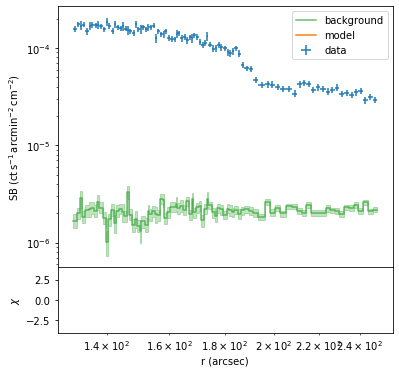

In [6]:
a3667_chandra_profile.rebin(130, 250,method="min_cts",min_cts=200,log_width=0.005,lin_width=1)
a3667_chandra_profile.plot(scale="loglog")

- For *Chandra* observations, the PSF is small enough to use an identity smoothing matrix, which is the default setting.
- For *XMM-Newton*, a King profile smoothing matrix is essential to account for the broad PSF. The parameters of the profile are provided in the PSF calibration files.

In [7]:
a3667_chandra_profile.set_smooth_matrix("identity", king_alpha=1.4,king_rc=10,sigma=1)

# Set models
Set a double power law model and load it into the profile.

The `+` operator can add multiple model instances into a compound model instance.

Here we use the combination of a `DoublePowerLaw` model and a `Constant` model, which represents the ICM emission and the X-ray sky background.

In [8]:
dpl = sbfit.model.DoublePowerLaw()
cst = sbfit.model.Constant()

a3667_chandra_profile.set_model(dpl + cst)

In [9]:
print(a3667_chandra_profile.model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <DoublePowerLaw(norm=1., a1=0.1, a2=1., r=1., c=2.)>

    [1]: <Constant(norm=0.)>
Parameters:
    norm_0 a1_0 a2_0 r_0 c_0 norm_1
    ------ ---- ---- --- --- ------
       1.0  0.1  1.0 1.0 2.0    0.0


Before fit, set initial parameters that make the model profile close to the observed profile.

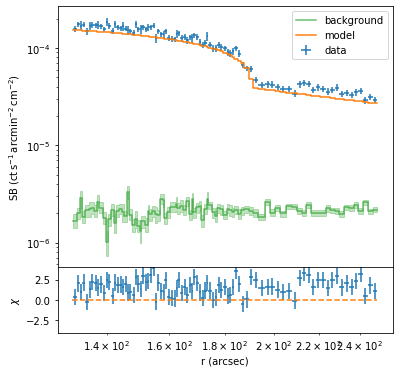

In [14]:
a3667_chandra_profile.model.norm_0 = 4e-4
a3667_chandra_profile.model.a1_0 = 0
a3667_chandra_profile.model.a2_0 = 0.6
a3667_chandra_profile.model.r_0 = 191
a3667_chandra_profile.model.c_0 = 2.4
a3667_chandra_profile.model.norm_1 = 5e-7


a3667_chandra_profile.calculate()
a3667_chandra_profile.plot()


Set parameter constraints for the model in case that the optimizer goes too far.

In [11]:
a3667_chandra_profile.model.norm_1.fixed = True

a3667_chandra_profile.model.norm_0.bounds = (1e-4, 6e-4)
a3667_chandra_profile.model.a1_0.bounds = (-0.7, 0.3)
a3667_chandra_profile.model.a2_0.bounds = (0.4, 1.1)
a3667_chandra_profile.model.r_0.bounds = (150, 220)
a3667_chandra_profile.model.c_0.bounds = (1.8, 3.3)

# Fit

In [15]:
a3667_chandra_profile.fit(show_step=True, tolerance=0.01)

Start fit
C-stat: 346.196
[4.00e-04 0.00e+00 6.00e-01 1.91e+02 2.40e+00]
C-stat: 100.444
[ 4.06050436e-04 -2.67137895e-06  5.56866440e-01  1.91013239e+02
  2.44832681e+00]
C-stat: 90.673
[4.07786231e-04 1.20676742e-05 5.56652684e-01 1.91044801e+02
 2.47346747e+00]
C-stat: 90.511
[ 4.07703698e-04 -9.87317700e-05  5.57278423e-01  1.91068081e+02
  2.47879077e+00]
C-stat: 90.511
[ 4.07703698e-04 -9.87317700e-05  5.57278423e-01  1.91068081e+02
  2.47879077e+00]
Iteration terminated.
Degree of freedom: 86; C-stat: 90.5107
norm_0:	4.08e-04
a1_0:	-9.87e-05
a2_0:	5.57e-01
r_0:	1.91e+02
c_0:	2.48e+00
Uncertainties from rough estimation:
norm_0:	2.716e-05
a1_0:	2.063e-02
a2_0:	4.865e-02
r_0:	2.003e-01
c_0:	1.621e-01


90.51069613615567

The uncertainties here are obtained from the Hessian matrix in the fit routine. To better estimate the uncertainties, 
we need to perform a Monte-Carlo Markov Chain analysis.

Let's have a look of the best-fit profile first.

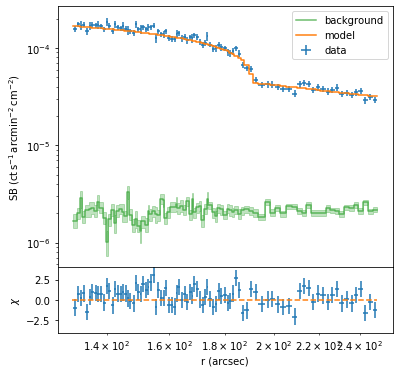

In [20]:
a3667_chandra_profile.calculate()
a3667_chandra_profile.plot(scale="loglog")

Now we use Monte-Carlo Markov Chain method to estimate the uncertainties. It takes hours to finish.

In [16]:
a3667_chandra_profile.mcmc_error(nsteps=5000, burnin=500)

100%|██████████| 5000/5000 [4:14:59<00:00,  3.06s/it]  

norm_0:	0.0004109230243782563	+2.635e-05	-3.342e-05
a1_0:	0.07662914689543374	+6.011e-02	-5.210e-02
a2_0:	0.5632834244633022	+5.223e-02	-5.326e-02
r_0:	191.06619860779801	+7.415e-01	-3.469e-01
c_0:	2.341633374918749	+2.299e-01	-1.040e-01


The corner plot

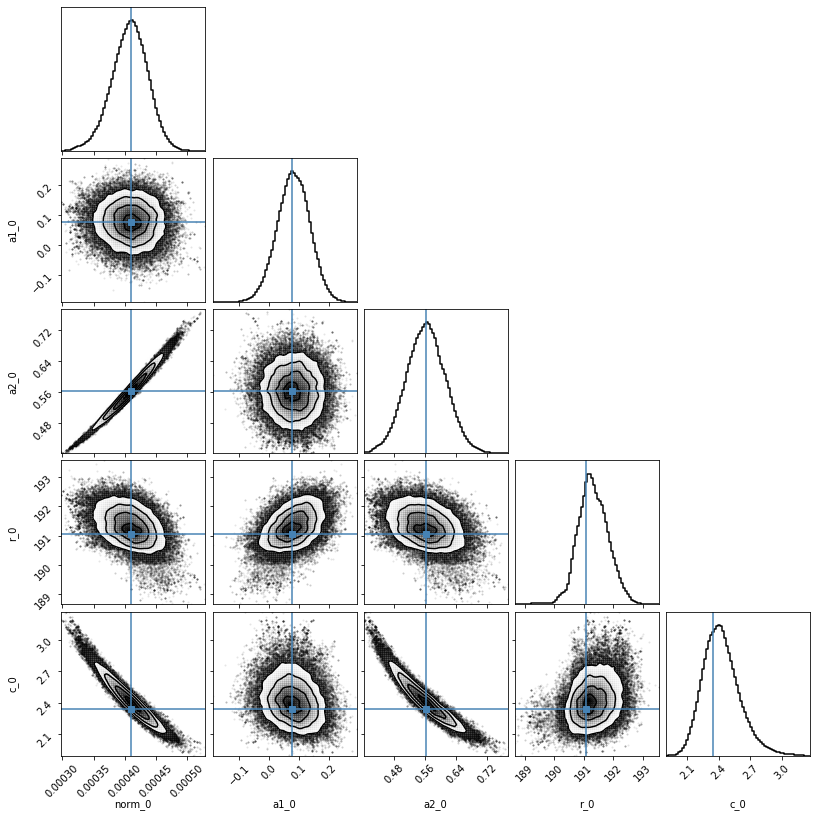

In [17]:
a3667_chandra_profile.plot(plot_type="contour")

Let's have a look how the MCMC chains walk.

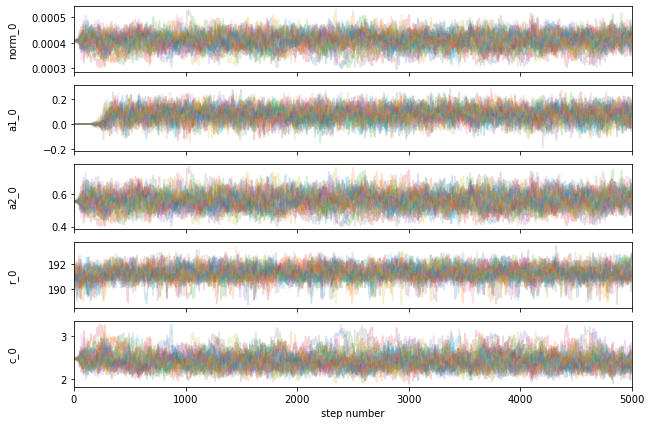

In [18]:
a3667_chandra_profile.plot(plot_type="mcmc_chain")

The uncertainties are stored in the `error` attribute.

In [22]:
print(a3667_chandra_profile.error)

OrderedDict([('norm_0', (-0.0001161550959459374, 0.00017582104069271547)), ('a1_0', (0.1246562346145155, -0.012366244840581183)), ('a2_0', (-0.21978370273262526, 0.3234329256974142)), ('r_0', (2.2220377039538732, -1.2221756410102955)), ('c_0', (0.7662772913197773, -0.4141295370661364))])


In [19]:
a3667_chandra_profile.calculate()

/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/profile.py:354: RuntimeWarning: invalid value encountered in true_divide
/Users/xyzhang/anaconda3/envs/my/lib/python3.7/site-packages/sbfit-0.1.2-py3.7.egg/sbfit/statistics.py:31: RuntimeWarning: invalid value encountered in true_divide


111.03038901613105